## Spark Architecture

#### Spark Cluster Runtime Architecture

**Cluster** : Pool of computers working together but viewed as a single system
- Example Cluster config
    - Worker Node Capacity
        - 16 CPU Cores
        - 64 GB RAM
    - Cluster Capacity
        - 160 CPU Cores
        - 640 GB RAM

- will use the spark-submit command and submit my spark application to the cluster
- Request will go to the YARN/Kubernetes/Mesos resource manager.
- YARN RM wil create one *Application Master container* on a worker node and start my application's main() method in the container, here container is an isolated virtual runtime environment. Comes with some CPU and memory allocation.
Example- let's assume YARN RM gave 4 CPU Cores and 16GB memory to this container and started it on a worker node, where this worker node has total 16CPU cores and 64GB of memory.
- Application Master Container - The container is running the main() method of my application either in Python or Scala. But Spark is written in Scala, and it runs in the Java virtual machine. Scala is a JVM language, and it always runs in the JVM. So they created a Java wrapper on top of the Scala code. And then they crated a Python wrapper on top of the Java wrappers, and this Python wrapper is known as PySpark.
- So here we have Python code in my main() method. This python code is designed to start a Java main() method internally. So PySpark application will start a JVM application. Once we have the JVM application, the PySpark wrapper will call the Java Wrapper using the Py4J connection. Py4J allows a Python application to call a Java application. It will always start a JVM application and call Spark APIs in the JVM. The actual Spark application is always a Scala application running in the JVM, BUT PySpark is calling Java Wrapper using Py4J, and Java Wrapper runs Scala code in the JVM.
- PySpark main method is my PySpark Driver and JVM application here is my Application Driver, Spark application driver is the main method of our application. So for PySpark we would have PySpark Driver + Application Driver, for Scala we will have only Application Driver.
- Spark application is a distributed application in itself, means application driver distributes the work to others. Driver doesn't perform any data processing work, instead it will create some executors and get the work done from them. After starting, the driver will go back to the YARN RM and ask for some more containers.
- RM will create some more containers on worker nodes and give them to the driver. 
Ex: assume we got 4 new containers, each comes with 4 CPU Cores and 16 GB of memory, now the driver will start spark executor in these containers. Each container will run one SPARK executor, and the Spark executor is a JVM application. So driver is a JVM application and executor is also a JVM application. These executors are responsible for doing all the data processing work. The driver will assign work to the executors and monitor them, and manage the overall application, but the exectors do all the data processing.
- Application Master Container[[PySpark Driver + JVM/Application Driver]] -> cluster RM[YARN] -> Workers[JVM executors, Python Worker]  
if using some additional Python libraries that are not part of the PySpark, ex- UDFs
- Python worker is a Python runtime environment, and need them only if using some python specific code or libraries. PySpark is python wrapper on java code. So as long as we using only PySpark, do not need Python Runtime environment, All the PySpark code is translated into Java code, and it runs in the JVM. Executors will create a Python Runtime Environment so they can execute our Python Code.

#### Spark Submit and Important Options

**Spark Submit** : A command line tool that allows to submit the Spark application to the cluster
ex- 
    - spark-submit --class <main class> --master <master-url> --deploy-mode <deploy-mode> <application-jar/pyspark script> 
    [application-args]  
    - spark-submit --master yarn --deploy-mode cluster --driver-cores 2 --driver-memory 8G --num-executors 4 --executor-cores 4 --executor-memory 16G hello-spark.py  
    - spark-submit --class myclass.something.HelloSpark --master yarn --deploy-mode cluster --driver-cores 2 --driver-memory 8G --num-executors 4 --executor-cores 4 --executor-memory 16G hello-spark.jar  
- --class : Not applicable for PySpark
- --master : YARN, local[3]
- --deploy-mode : client/cluster
- --conf : spark.executor.memoryOverhead = 0.20
- --driver-cores : 2
- --driver-memory : 8G
- --num-executors : 4
- --executor-cores : 4
- --executor memory : 16G



#### Deploy Modes - Client/Cluster mode

- Cluster Mode : Driver runs in the cluster, allows to submit the application and log off from the client machine, coz the driver & executors are running on the cluster, nothing active on client's machine. Runs faster coz driver is closer to executors.
    - No dependency on client machine
    - Performance
- Client Mode : Driver runs in client machine, when driver is local, can easily communicate with the driver and show it back to us.
    - spark-shell, pyspark, spark-sql : gives interacive method to work with Spark, run the code and show us the results
    - Notebooks

#### Spark Jobs - Stage, Shuffle, Task, Slots

**Spark Data Frame API Categores**
- Transformations
    - Used for transforming data
    - Furhter classification
        - Narrow dependency
            - peformed in parallel on data partitions
            - ex- select(), filter(), withColumn(), drop()
        - Wide dependency
            - Pefrormed after grouping data from multiple partitions
            - ex- groupBy(), join(), cube(), rollup() and agg(), repartition()
- Actions 
    - Used to trigger some work(Job)
    - Example: read(), write(), collect(), take() and count()
    - All spark actions trigger one/more Spark jobs.

- Spark will run each code block as one spark job in other words each spark action runs as a spark job that contains all the transformations of its code block, so we will look for actions to separate spark code blocks
- BLOCK(Decide by each action occurred) :: 0 : (Read Action) 
`surveyRawDF = spark.read.option("header", "true).option("inferSchema", "true").cav(args(0))` 

- BLOCK(Decide by each action occurred) :: 1 : (Collect Action) 
    - ###### Wide Transformation 1 : reparition
    `patitioinedSurveyDF = surveyRawDF.repartition(numParitions=2)`  
    - ###### 2(narrow transformation-Where), 3(narrow transformation - Select), 4(Wide Transformation-groupBy), 5(narrow trans-count)
    `countDF = patitioinedSurveyDF.where("Age < 40").select(col="Age:, cols="Gender","Country","state").groupBy("Country").count()`  
    - ###### ACTION - collect()
    `logger.info(countDF.collect().mkString("->"))`  

- **BLOCK 1** : let's consider this block 
    - Application Driver will take this block, compile it and create a Spark Job. But this job will be performed by the executors, coz the Driver doesn't perform any data processing job. Driver will break this job into smaller tasks and assign them to executors.
    - Driver will create a *logical query plan* for each spark job.
    - Job 2(coz job1 is to read csv above) : will start with surveyDF and repartition it to create partitionedSurveyDF and then apply 4 transformations to create the countDF  
    *Logical Plan* :: surveyDF -> REPARTITION(yields partitionedSurveyDF) -> [ WHERE -> SELECT -> GROUP BY -> COUNT(yields countDF) ]
    - Once we have the logical plan, the driver will start breaking this plan into stages. Driver will look at this plan to find out the WIDE Transformations. Here we have 2 Wide transformation(repartition() & groupBy() method) in CODE BLOCK 1. So the driver will break this plan after each wide transformation, and our logical plan broken down into 3 stages, each stage can have one/more narrow transformations and the last operation of the stage is a WIDE transformation. 
        - STAGE 1 :: REPARTITION
        - STAGE 2 :: [WHERE, SELECT, GROUPBY]
        - STAGE 3 :: COUNT
    - Spark can't run these stages in parallel, it should finish the 1st stage, and then only can start the next stage coz the output of the first stge is an input for the next stage

        - STAGE 2 :: [WHERE, SELECT, GROUPBY]
        - STAGE 3 :: COUNT

**STAGE 1** :: REPARTITION : read surveyDF and repartition it to create partitionedSurveyDF(2 partition). The final output of the stage must be stored in an *exchange buffer(WRITE EXCHANGE here)*. Output of this stage becomes the input of the next stage, so the next stage starts with an *exchange buffer(READ EXCHANGE here)*. Spark is a distributed system so both exchange may be on 2 diff/same worker nodes. So we must consider a copy of data partitions from the WRITE Exchange to Read Exchange, and this copy operation is popularly known as the Shuffle/Sort operation. Where Shuffle/Sort is not a plain copy of data, a lot of things happens here. So bascially Shuffle/Sort will move data from the WRITE Exchagne to Read Exchange. Notice stage ends with a WIDE Transformation, and hence it requires a Shuffle/Sort of the data, which is an expensive operation in the Spark Cluster and it requires a Write Exchange Buffer and a Read Exchange Buffer. The data from Write Exchange Buffer is sent to the Read Exchange Buffer over the network.

TASK1[REPARITION(2)] ====> |Write Exchange(stage 1| 

**STAGE 2** :: [WHERE, SELECT, GROUPBY] : Read Exchange has got 2 partitions coz of above repartition(2) operation and also configured spark shuffle partitions to ensure we preserve those 2 partitions in the Read Exchange. So we have 2 input partitions here and can run these transformations in parallel on those 2 partitions, here we have 2 parallel tasks in this stage. This stage also ends with a Wide Transformation, again we need a Shuffle/Sort operation here  

-------------- ====>partition 1 -> TASK1[WHERE, SELECT, GROUPBY] >  
|Read Exchange from stage1 input|-----------------------------------------------------|Write Exchange(stage 2)|  
-------------- ====>partition 2 -> TASK2[WHERE, SELECT, GROUPBY] >  

**STAGE 3** :: COUNT : Assume 2 partitions in Stage 2's Write Exchange, so this stage's task can also run in parallel

-------------- ====>partition 1 -> TASK1[COUNT] >  
|Read Exchange from stage 2 input|  
-------------- ====>partition 2 -> TASK2[COUNT] >  

Summary:
- Job : Spark creates 1 job for each action, may contain a series of multiple transformations. Spark engine will optimize those transformations and create a logical plan for the job.
- Stage : Spark will break the logical plan at the end of every Wide Transformation and create 2/more stages. If no wide trans plan will be a single-stage plan, but if have N Wide Transformations, plan should have N+1 stages.
- Shuffle/Sort : Data from one stage to another stage is shared using the shuffle/sort operation.
- Task : Each stage may be executed as one or more parallel tasks. Task is a smallest unit of work in a Spark job. Spark Driver assigns these tasks to the executors and asks them to do the work. Executor needs the Task Code & Data Partitions to perform the task. Driver is responsible for assigning a task to the executor. Executor will ask for the code/API to be executed for the task, and also DF partition on which to execute the given code. The application driver facilitates both these things to the executor, and the executor performs the task.

How Above plan will fit into the cluster?  
Consider we have a driver and 4 executors(on 4 worker nodes), each executor will have one JVM process. But we assigned 4 CPU Cores to each executor with 16GB memory, so my Executor-JVM can create 4 parallel threads on each worker node and that's the ***SLOT*** capacity of my executor. So each executor can have 4 parallel threads, and we call them executor slots. The driver knows how many slots do we have at each executor, and it is going to assign tasks to fit in the executor slots.

client Machine(spark-submit cluster Mode) -> YARN RM -> Driver JVM -[4 Workers with thier own Executor-JVM(each with 4 slots)]

Collect() Action : requires each task to send data back to driver. So the tasks of the last stage will send the result back to the driver over the network. The driver will collect data from all the tasks and present it to you. If we have an action to write the result in a data file, in that case all the tasks will write a data file partition and send the partition details to the driver. Driver considers the job done when all the tasks are successful. If any tasks fails, the driver might want to retry it. It can restart the task at a diff executor. If all retries also fail, then the driver returns an exception and marks the job failed.

#### Spark SQL Engine and Query Planning

<img src="/workspaces/Atlas/DSA/images/query_planning.png">

- Unresolved Logical Plan : in-case of DataFrame API code, spark will take action and all it's preceding transformations to consider it a single job. Similarly if have a SQL expression, Spark considers 1 SQL expression as one Job. Each job represents a *logical query plan*. This 1st logical plan is a user-created logical plan.
- Spark SQL Engine : unresolved logical plan goes to Spark SQL Engine whether DF API/SQL. For spark they are nothing but a Spark Job represented as a logical plan. Spark SQL Engine will process logical plan in 4 stages  
Ex- SELECT prod_qty + 5 FROM sales
    - Analysis : parse code for errors and incorrect names using catalog, might apply an implicit casting to the 'prod_qty' to perform and validate the addition operation. So analysis phase will parse code and create a fully resolved plan.
    - Logical Optimization : Applies standard rule-based optimizations to the logical plan. Ex-
        - Constant folding
        - Predicate pushdown
        - Partition pruning
        - Null propagation
        - Boolean expression simplification
    - Physical Planning(Physical plans + cost model + selected physical plan) : Takes a logical plan and generates one/more physical plans in this phase. Physcial planning applies cost-based optimization, calculate each plan's cost and finally select the plan with the least cost. At this stage, mostly use diff join algorithms to create more than one physcial plan. For ex they might create 1st plan using Broadcast join and another using Sort merge and more using shuffle hash join. Then apply a cost to each plan and choose the best one.
    - Code Generation : Best physical plan goes into code generation, and engine will generate Java byte code for the RDD operations in the physical plan. And that's why Spark is also said to act as a compiler, coz it uses start of the art compiler technology for code generation to speed up execution.


## Performance and Applied Understanding

#### Spark Memory Allocation

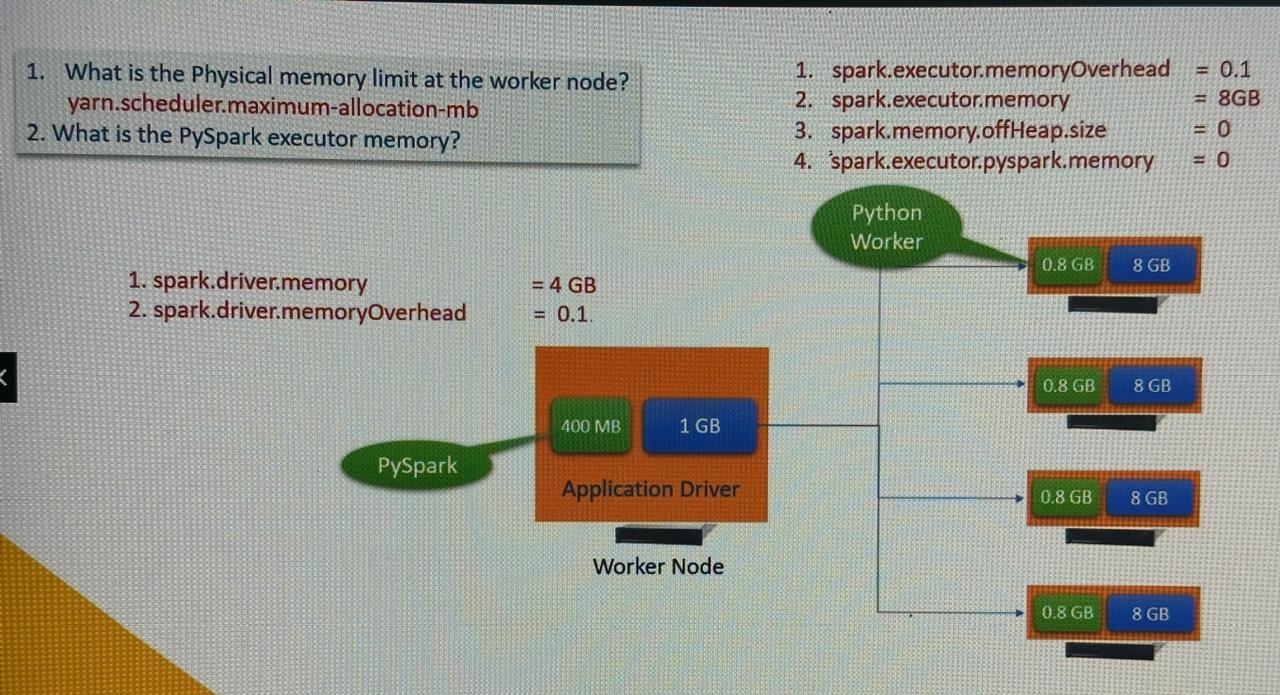

In [2]:
from IPython.display import Image
Image("/workspaces/Atlas/AtlasCodeLearn/ASonD/images/SparkMemoryAllocation.jpeg")

***Driver Memory Allocation***
Let's consider we submitted a spark application in a YARN cluster. YARN RN will allocate an Application Master Container and start the driver JVM in the container. The driver will start with some memory allocation which requested.
- We an ask for the driver memory using two configuration
    - `spark.driver.memory = 1GB`  -> JVM Memory : YARN RM will allocate 1GB of memory for the driver JVM. Spark driver uses all the this JVM Heap but nothing from below overhead's/384MB.
    - `spark.driver.memoryOverhead = 0.1(Default)`  -> MAX(10% or 384MB) : Allocate 10% of above requested memory or 384MB, whichever is higher for container overhead. As we asked for 1GB so 10% of it will be 100MB, but 384MB(Default is higher), so it will allocate 384MB for overhead. The overhead memory is used by the container process or any other non-JVM process within the container.
    - So in our case total memory of Application Master Container is = 1GB + 384MB
- For our case let's consider `spark.driver.memory = 4GB` Heap Memory & `spark.driver.memoryOverhead = 0.1(Default)`=400MB coz 400 > 384 overhead memory for Driver requested.
    - Spark driver JVM can't use more than 4GB
    - non-JVM workload in the container can't use more than 400MB.
    - And Application Master Container can't use more than 4.4GB of memory in total. If any of these limits are violated, we will see an <font color='red'>*OOM exception*</font>.

***Executor Memory Allocation***
Now the *Driver* started with 1GB of JVM Heap, so the driver will again request for the executor containers from the YARN. YARN RM will allocate a bunch of executor containers. So a Spark driver will ask for executor container memory using 4 configuration, total memory Allocated to the executor container is the sum of the following conig:
- Here Total we will get 8GB JVM Heap Memory requested + (8GB*10%=800MB) OverheadMemory + 0+ 0 => 8.8GB each executor container will get : Driver will ask for 8.8GB containers to the YARN RM. But if each worker has only 6GB then it's can't provide 8.8GB, in such cases when YARN RM is used can check 2 properties - `yarn.scheduler.maximum-allocation-mb` & `yarn.nodemanager.resource.memory-mb`
Ex- InstanceType=c4.large(3.75GB RAM), `yarn.scheduler.maximum-allocation-mb=1792MB`, EMR cluster will start with the default value of 1792MB, meaning we can't ask for a container of higher than 1.792GB.
    - **Overhead Memory** :: `spark.executor.memoryOverhead = 0.1` (Default), will be using overhead memory as shuffle exchange or reading partition data from remote storage etc. Lack of enough overhead memory will cost an <font color='red'>*OOM exception*</font>. Overhead memory is often overlooked, but it is used as shuffle exchange/netowrk read buffer.
    - **Head Memory/JVM Heap** :: `spark.executor.memory = 8GB`(Requested)
    - **Off Heap Memory** :: `spark.memory.offHeap.size` = 0(Default)
    - **PySpark Memory** :: `spark.executor.pyspark.memory` = 0(Default)

- What is the Physical memory limit at the worker node? : `yarn.scheduler.maximum-allocation-mb`
- What is the PySpark executor memory? : We don't need to worry about PySpark memory if we write Spark Application in Java/Scala. PySpark is not a JVM Process, so we won't get anyting from those 8GBs. All we have is 800MB of overhead memory. Some 300-400MB of this is constantly consumed by the container processes and other internal processes. So PySpark will get approximately 400MB. *iF pYsPARK consumes more than what can be accommodated in the overhead, we will see an <font color='red'>OOM error</font>*
- From YARN perspective, we have a container and the container has got some memory.
[Heap Memory[JVM Process], Overhead/OS Memory[non-JVM Process]] =>we call it Driver Memory when running a Driver in this container, similarly executor memory when the container is running an executor.

#### Spark Memory Management

***How Spark utilizes JVM Heap memory?***
in our case :: `spark.executor.memory=8G` & `spark.executor.cores=4`

**Executor Process Memory View**:
- HEAP Memory is further broken down into 3 parts : 
    - Reserved Memory 300MB + : Fixed Reserve for Spark Engine
    - Spark Executor Memory Pool 4620MB(60% of 8000MB-300MB) + : controlled by the config `spark.memory.fraction=0.6` with default value 60%.
    - User Memory Pool 3080MB(40% of 8000MB-300MB)

    - **Reserved Memory Pool 300MB**: Reserved pool is gone for the Spark engine itself, we can't use it. 
    - **Spark Memory pool 4620MB**:  is main executor memory pool which will use for 
        - data frame operations : if using DF operations, they don't use the user memory even if the DF is internally translated and compiled into RDD.
        - caching.
    - **User Memory pool 3080MB**: used for non-dataframe operations, such as
        - User-defined data structures (HashMap)
        - Spark internal metadata
        - UDFs created by the user
        - RDD conversion operations : only if we apply RDD operations directly in our code.
        - RDD lineage and dependency
